In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from tqdm import tqdm
import pycountry
from countryinfo import CountryInfo
import pycountry
from countryinfo import CountryInfo
from tqdm import tqdm
from Countrydetails import country


In [2]:
path = '/Users/g_private/Library/CloudStorage/OneDrive-Personal/Universität Zürich/FS25/Complex Newtworks Yas/data/co-attention.csv'
df=pd.read_csv(path)
df=df.dropna()

df['countries_mentioned_list']=df['countries_mentioned'].apply(lambda x: x.split(','))
df['affiliations_list']=df['affiliations'].apply(lambda x: x.split(','))
df['Mention_number']=df['countries_mentioned_list'].apply(lambda x: len(x))

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst]
)
df['affiliations_list'] = df['affiliations_list'].apply(
    lambda lst: [c.strip().title()           # remove spaces, standard capitalisation
                 .replace('P.R. China', 'China')
                 .replace('Pr China', 'China')
                 .replace('People’s Republic Of China', 'China')
                 .replace('Cn', 'China')
                 for c in lst])

# flatten with respect to to the aggregated_value column
df = df.loc[df.index.repeat(df['aggregated_value'])].reset_index(drop= True)

df['affiliations_list'] = df['affiliations_list'] \
    .apply(lambda codes: [c.upper() for c in codes])

# List of columns to remove
cols_to_drop = [
    'countries_mentioned',
    'affiliations',
    'aggregated_value',
    #'affiliations_list',
    'Mention_number'
]

# Option 1: create a new DataFrame without those columns
df= df.drop(columns=cols_to_drop)

df['countries_mentioned_list'] = df['countries_mentioned_list'] \
    .apply(lambda codes: [c.upper() for c in codes])
# remove entries with only 1 country mentioned
df = df[df['countries_mentioned_list'].apply(len) > 1]

df['countries_mentioned_list'] = df['countries_mentioned_list'].apply(lambda lst:[c for c in lst if len(c) < 4]) 

df = df[df['countries_mentioned_list'].apply(len) > 1]

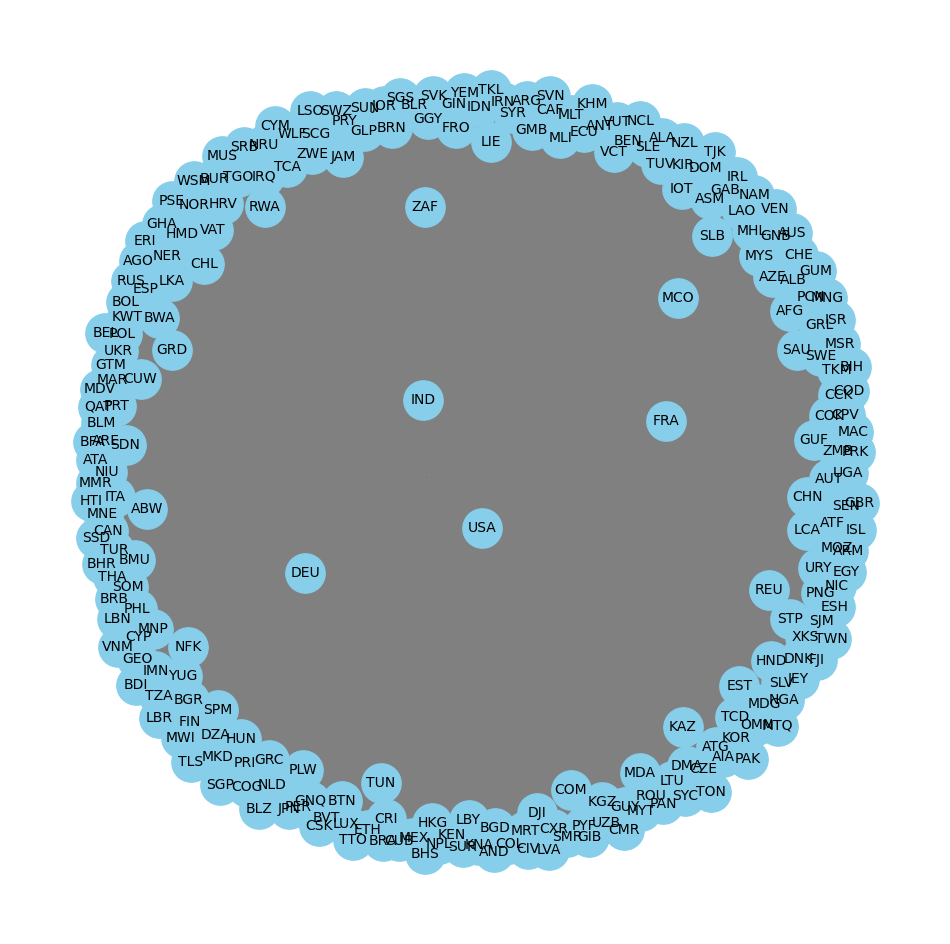

In [4]:
import matplotlib.pyplot as plt
import networkx as nx
import itertools
from collections import Counter
from math import comb

def build_fractional_comention_network(df, list_col='countries_mentioned_list', min_weight=0.005):
    """
    Pair-normalized fractional co-mention network:
      - Each paper with k subregions contributes 1 / comb(k,2) to each pair.
      - Edges with total weight ≥ min_weight appear in the graph.
      - Self‐loops are explicitly removed.
    """
    pair_weights = Counter()

    # 1) accumulate fractional weights per paper
    for regs in df[list_col]:
        uniq = [r for r in regs if r is not None]
        k = len(uniq)
        if k < 2:
            continue
        frac = 1.0 / comb(k, 2)
        for u, v in itertools.combinations(sorted(uniq), 2):
            pair_weights[(u, v)] += frac

    # 2) build graph
    G = nx.Graph()
    all_regs = {r for regs in df[list_col] for r in regs if r is not None}
    G.add_nodes_from(all_regs)

    for (u, v), w in pair_weights.items():
        if w >= min_weight:
            G.add_edge(u, v, weight=w)

    # 3) remove any accidental self loops
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

# --- parameters you can tweak ---
MIN_WEIGHT = 0.01   # drop edges whose total fractional weight < 1% of a paper
SPRING_K   = 20    # repulsion parameter for layout
FIGSIZE    = (12, 12)

# build & draw
G_frac = build_fractional_comention_network(df, list_col='countries_mentioned_list', min_weight=MIN_WEIGHT)

# extract and normalize edge‐widths
weights = [G_frac[u][v]['weight'] for u, v in G_frac.edges()]
mn, mx = min(weights), max(weights)
widths = [0.5 + 4.5 * ((w - mn) / (mx - mn)) for w in weights]

plt.figure(figsize=FIGSIZE)
pos = nx.spring_layout(G_frac, k=SPRING_K, seed=42)

nx.draw_networkx_nodes(G_frac, pos,
                       node_size=800,
                       node_color='skyblue')
nx.draw_networkx_edges(G_frac, pos,
                       width=widths,
                       edge_color='gray',
                       alpha=0.7)
nx.draw_networkx_labels(G_frac, pos, font_size=10)

#plt.title(f"Fractional Subregion Co‐mention (min_weight={MIN_WEIGHT})")
plt.axis('off')
plt.show()


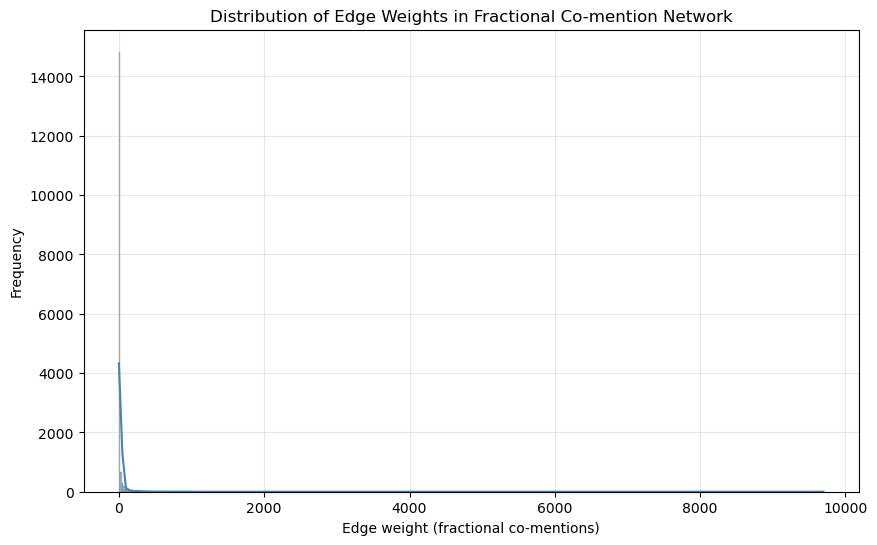

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract edge weights
weights = [d['weight'] for _, _, d in G_frac.edges(data=True)]

plt.figure(figsize=(10,6))

# Histogram with KDE
sns.histplot(weights, bins=500, kde=True, color="steelblue", edgecolor="black")

plt.xlabel("Edge weight (fractional co-mentions)")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Weights in Fractional Co-mention Network")
plt.grid(alpha=0.3)
plt.show()


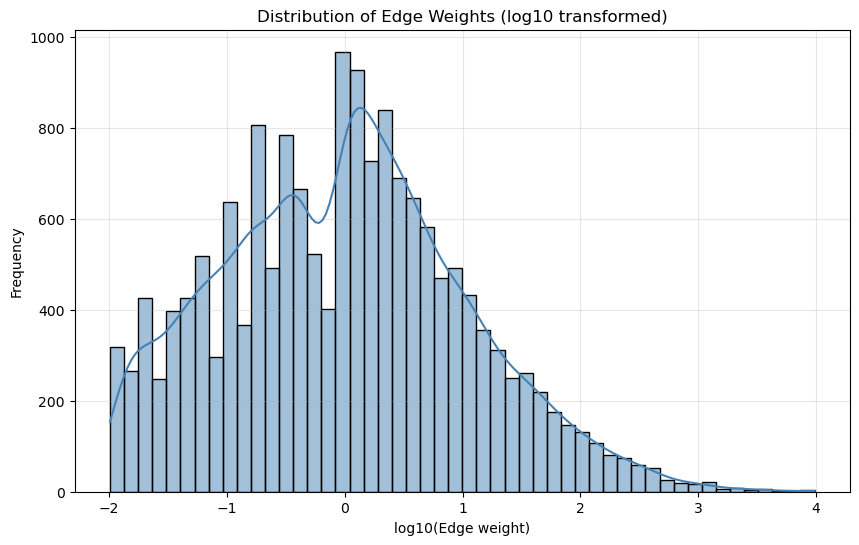

In [15]:
log_weights = np.log10(weights)

plt.figure(figsize=(10,6))
sns.histplot(log_weights, bins=50, kde=True, color="steelblue", edgecolor="black")

plt.xlabel("log10(Edge weight)")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Weights (log10 transformed)")
plt.grid(alpha=0.3)
plt.show()


In [16]:
import numpy as np

print("Min weight:", np.min(weights))
print("25th percentile:", np.percentile(weights, 25))
print("Median:", np.median(weights))
print("Mean:", np.mean(weights))
print("75th percentile:", np.percentile(weights, 75))
print("Max weight:", np.max(weights))


Min weight: 0.010173160173160174
25th percentile: 0.16666666666666666
Median: 1.045959595959596
Mean: 21.12476935831487
75th percentile: 4.593827371458949
Max weight: 9696.545173068933
